In [1]:
# Import our standard libraries.
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns  # for nicer plots
sns.set(style='darkgrid')  # default style
import tensorflow as tf
np.set_printoptions(precision=3, suppress=True)  # improve float readability
from sklearn import datasets

## Iris Classification

We will train a classifier to predict 3 iris varieties from 4 features of each flower. Note: we are not doing image classification here!

![An image](https://drive.google.com/uc?id=12gf4Q0K45gvw-tUDt_sWsbAl-f0klhib)


In [2]:
# Load the data
iris = datasets.load_iris()
X = iris.data
Y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('feature names:', feature_names)
print('class names:', class_names)
print('First example:', X[0], Y[0])

X shape: (150, 4)
Y shape: (150,)
feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
class names: ['setosa' 'versicolor' 'virginica']
First example: [5.1 3.5 1.4 0.2] 0


## Data Processing

* Shuffle
* Split into train/test
* Apply mean and variance normalization

In [3]:
np.random.seed(0)
shuffled_indices = np.random.permutation(range(len(Y)))
X = X[shuffled_indices]
Y = Y[shuffled_indices]

X_train = X[0:100]
Y_train = Y[0:100]
X_test = X[100:150]
Y_test = Y[100:150]

X_train_means = np.mean(X_train, axis=0)
X_train_stds = np.std(X_train, axis=0)
X_train = (X_train - X_train_means) / X_train_stds
X_test = (X_test - X_train_means)/ X_train_stds

## Sparse vs Dense Representation

In [4]:
# Convert Y from sparse to dense if needed
# one-hot [0, 0, 1] -> 2
# one-hot [0, 1, 0] -> 1
# one-hot [1, 0, 0] -> 0
Y_train_dense = tf.keras.utils.to_categorical(Y_train)
print(Y_train_dense.shape)
print(Y_train_dense[:6])

(100, 3)
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


## Softmax Regression Functional Form

We will use *softmax regression*, which extends *logistic regression* to the multiclass setting. Our model will make predictions for input examples $X$ by:

\begin{align}
\hat{Y} = h_W(X) = \phi(XW^T) =
\phi\begin{pmatrix}
x_{0,0} & x_{0,1} & x_{0,2} & x_{0,3} \\
x_{1,0} & x_{1,1} & x_{1,2} & x_{1,3} \\
\vdots & \vdots & \vdots & \vdots \\
x_{m-1,0} & x_{m-1,1} & x_{m-1,2} & x_{m-1,3} \\
\end{pmatrix}
\begin{pmatrix}
w_{0,0} & w_{1,0} & w_{2,0} \\
w_{0,1} & w_{1,1} & w_{2,1} \\
w_{0,2} & w_{1,2} & w_{2,2} \\
w_{0,3} & w_{1,3} & w_{2,3} \\
\end{pmatrix}
\end{align}

A few notes about this computation:

* Our X has shape (100 x 4): 100 examples and 4 features
* Our W has shape (3 x 4): 3 classes and 4 features. The indices above are reversed because we've taken the transpose of W: the first column of $W^T$ contains the weights for the first class.
* The result will have shape (100 x 3): 3 probabilities corresponding to the 3 classes for each of the 100 examples.
* $\phi$ is the softmax function: $\frac{e^{z_i}}{\sum_j e^{z_j}}$. It is applied to the rows of $XW^T$.

More detailed background [here](http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression/).

## Softmax Normalization

In [5]:
# Remember the sigmoid function.
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

# Our softmax function will normalize over the rows of the input matrix.
def softmax(z):
  """z has shape (m, n): examples, classes"""
  (m, n) = z.shape

  # First exponentiate each value
  exps = np.exp(z)

  # Get the sum of each row and normalize
  row_sums = np.sum(exps, axis=1)
  for i in range(m):
    exps[i,:] /= row_sums[i]

  # Fancy/tricky way to do row-wise sums in numpy:
  # return np.divide(exps.T, np.sum(exps, axis=1)).T

  return exps

# Try an example.
v = np.array([[1,2,3],
              [0,2,4]])
print(softmax(v))

[[0.09  0.245 0.665]
 [0.016 0.117 0.867]]


## Making Predictions

Now, given some initial parameter values (below), compute the model's initial predictions.

In [6]:
# Initial parameter values.
# W = np.random.uniform(size=(3,4))
W = np.ones((3,4))

# Compute predictions.
preds = softmax(np.dot(X_train, W.T))
print('predictions:\n', preds[:6])
print('label predictions:\n', np.argmax(preds, axis=1)[:6])
print('true labels:\n', Y_train[:6])

predictions:
 [[0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]]
label predictions:
 [0 0 0 0 0 0]
true labels:
 [2 1 0 2 0 2]


## Cross-Entropy Loss

We'll use the general form of *cross-entropy* loss:

\begin{align}
CrossEntropyLoss = \frac{1}{m} \sum_i \sum_j -y_j\log(\hat{y_j})
\end{align}

In this formula:

* $j$ indexes the classes (in our case [0,1,2]) and each $y$ has a dense representation like [0,0,1] which indicates class 2.
* *i* indexes over training examples, so we're computing an average loss (as usual).

In [7]:
def ce_loss(preds, Y):
  """
    preds are (m,n) m = number of examples, n = number of classes
    Y is (m,) -- array of sparse labels
    preds[0] = [.1, .1, .8] Y[0] = 2 Y_dense[0] = [0, 0, 1]
  """
  # Get the number of examples
  m = Y.shape[0]

  # Compute the first sum, the cross-entropy for each example, using
  # the rows of the predictions and corresponding labels.
  # Note that we need the dense (one-hot) labels.
  Y_dense = tf.keras.utils.to_categorical(Y)
  # [.1, .1, .8] [0, 0, 1] -> [0, 0, -1*log(.8)] -> -1*log(.8)
  cross_entropy_values = - np.sum(Y_dense * np.log(preds), axis=1)

  # Here's a more efficient but tricky way to do this:
  # cross_entropy_values = -np.log(preds[range(m), Y])

  # Sum the per-example cross-entropy values.
  loss = np.sum(cross_entropy_values) / m

  return loss

#print(ce_loss(np.array([.1, .1, .8]), np.array([2])))
print(ce_loss(preds, Y_train))

1.0986122886681093


## Computing the Gradient

Again, it will turn out that the gradient computation is the same as it was for MSE with linear regression. A happy coincidence.

\begin{align}
\nabla J(W) &= \frac{1}{m}(h_W(X) - Y)^TX
\end{align}

Remember that our parameters $W$ are represented by a matrix of shape (3 x 4): 3 classes and 4 features. The gradient will include a partial derivative for every parameter, and is an average over gradients computed on each training example.

Let's review the matrix shapes:

* $h_W(X)$ is (100 x 3): 3 probabilities for each example.
* $Y$ is (100 x 3): this is the dense (one-hot) version of the labels, matching the shape of the predictions.
* $X$ is (100 x 4): 4 features for each example.
* The resulting product is (3 x 100)(100 x 4), giving a (3 x 4) output, which matches the shape of our parameters $W$.


In [8]:
# y' = [.1, .2, .7]  y = [0, 0, 1]  diff = y' - y = [.1, .2, -.3]
# d1 = [.1, .2, -.3]  x1 = [1, 2, 3, 4]
# (3 x 100) (100 x 4) -> (3 x 4)
# [ [ .1*1,  .1*2,  .1*3,  .1*4 ]
#   [ .2*1,  .2*2,  .2*3,  .2*4 ]
#   [-.3*1, -.3*2, -.3*3, -.3*4 ]
# ]
#
# We need the dense version of Y here
m = Y_train.shape[0]
Y_train_dense = tf.keras.utils.to_categorical(Y_train)
diff = preds - Y_train_dense
gradient = np.dot(diff.T, X_train) / m
print('gradient:\n', gradient)

gradient:
 [[ 0.337 -0.28   0.431  0.411]
 [-0.042  0.191 -0.089 -0.046]
 [-0.295  0.09  -0.342 -0.365]]


In [9]:
# Simplify and just compute the gradient for the first training example.
print(diff[0:1].T)
print(X_train[0:1])
print('gradient:\n', np.dot(diff[0:1].T, X_train[0:1]))

[[ 0.333]
 [ 0.333]
 [-0.667]]
[[-0.017 -0.543  0.76   1.567]]
gradient:
 [[-0.006 -0.181  0.253  0.522]
 [-0.006 -0.181  0.253  0.522]
 [ 0.011  0.362 -0.507 -1.045]]


## Running Gradient Descent

Let's put together the code for a single gradient descent step:

In [10]:
# Run gradient descent
m, n = X.shape  # m = number of examples; n = number of features (including bias)
learning_rate = 0.01

for _ in range(1000):
  preds = softmax(np.dot(X_train, W.T))
  loss = ce_loss(preds, Y_train)
  gradient = np.dot((preds - tf.keras.utils.to_categorical(Y_train)).T, X_train) / m
  W = W - learning_rate * gradient

print('labels:\n', Y_train[:6])
print('predictions:\n', preds[:6])
print('loss:', loss)
print('gradient:\n', gradient)
print('weights:\n', W)

labels:
 [2 1 0 2 0 2]
predictions:
 [[0.025 0.201 0.774]
 [0.084 0.673 0.243]
 [0.99  0.006 0.003]
 [0.007 0.154 0.838]
 [0.962 0.032 0.006]
 [0.014 0.081 0.905]]
loss: 0.43657251861677077
gradient:
 [[ 0.012 -0.026  0.026  0.023]
 [-0.01   0.026 -0.007  0.01 ]
 [-0.001 -0.    -0.018 -0.033]]
weights:
 [[0.539 1.556 0.295 0.347]
 [1.08  0.492 1.132 0.922]
 [1.381 0.951 1.573 1.731]]


## Evaluation

In [11]:
# Make predictions on the test data
test_preds = softmax(np.dot(X_test, W.T))
test_pred_labels = np.argmax(test_preds, axis=1)
print('Accuracy:', np.mean(test_pred_labels == Y_test))

Accuracy: 0.84


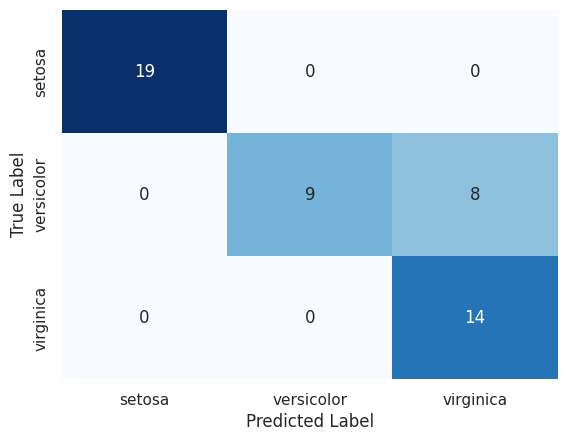

In [12]:
cf = tf.math.confusion_matrix(Y_test, test_pred_labels)
ax = sns.heatmap(cf, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names, cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

## Now with TensorFlow/Keras

In [13]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(
    units=3,                     # output dim
    input_shape=[4],             # input dim
    use_bias=False,              # we included the bias in X
    activation='softmax',        # apply a sigmoid to the output
    kernel_initializer=tf.ones_initializer,  # initialize params to 1
))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# As above, get predictions for the current model first.
preds = model.predict(X)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = Y_train,
  epochs=100,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
predictions:
 [[0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]]
loss: 0.992297887802124
W:
 [[ 0.272  2.881 -0.77  -0.696]
 [ 1.618 -0.275  2.141  0.16 ]
 [ 1.204  0.639  2.048  2.972]]


In [15]:
print(history.history['loss'])

[0.992297887802124, 0.8025609850883484, 0.6757325530052185, 0.6012971997261047, 0.5520737767219543, 0.5170604586601257, 0.49477916955947876, 0.47644829750061035, 0.4634079337120056, 0.452418714761734, 0.44413918256759644, 0.43610242009162903, 0.42947307229042053, 0.4228138029575348, 0.41787415742874146, 0.41321805119514465, 0.408703088760376, 0.4049006700515747, 0.40111109614372253, 0.39859044551849365, 0.39470741152763367, 0.39194750785827637, 0.38938385248184204, 0.38765501976013184, 0.38423338532447815, 0.38197246193885803, 0.38002708554267883, 0.3781062960624695, 0.3759465515613556, 0.3749600350856781, 0.3729705810546875, 0.37111321091651917, 0.369655042886734, 0.36837098002433777, 0.3671342432498932, 0.365773469209671, 0.36499157547950745, 0.36381736397743225, 0.36219605803489685, 0.3613615334033966, 0.3605702221393585, 0.3599521219730377, 0.358480840921402, 0.3578120172023773, 0.3566480576992035, 0.3561931550502777, 0.3551245629787445, 0.3549802005290985, 0.35369908809661865, 0.3

In [16]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == Y_test)
print(accuracy)
model.evaluate(x=X_test, y=Y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
0.9
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2304 


0.25506189465522766